**Reference: https://medium.com/@kevaldekivadiya2415/fine-tuning-llama-2-your-path-to-chemistry-text-perfection-aa4c54ff5790**

In [1]:
!pip install -q ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00
time: 263 µs (started: 2024-02-21 12:17:29 +00:00)


In [2]:
!pip install -qqq git+https://github.com/huggingface/transformers
!pip install -qqq git+https://github.com/huggingface/datasets
!pip install -qqq git+https://github.com/huggingface/peft
!pip install -qqq git+https://github.com/huggingface/accelerate
!pip install -qqq --upgrade bitsandbytes
!pip install -qqq git+https://github.com/huggingface/trl
!pip install -qqq --upgrade safetensors
!pip install -qqq -U flash-attn
!pip install -qqq evaluate
!pip install -qqq gputil psutil
!pip install -qqq wandb


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... 

In [3]:
import wandb

time: 443 ms (started: 2024-02-21 12:19:58 +00:00)


In [32]:
wandb.init(project="llama2_medqa_sft_padding_final", entity="drishtisharma96505", group='packing=False and padding = Left')

time: 13.3 s (started: 2024-02-21 12:40:57 +00:00)


In [33]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)
from peft import LoraConfig
from trl import SFTTrainer

time: 540 µs (started: 2024-02-21 12:41:11 +00:00)


In [34]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
dataset = load_dataset("medalpaca/medical_meadow_medqa", split="train")

print(f"Dataset Size: {len(dataset)}")
print(dataset[randrange(len(dataset))])

Dataset Size: 10178
{'input': 'Q:A 35-year-old obese man presents to the office complaining of chronic heartburn and nausea for the past 6 months. These symptoms are relieved when he takes 20 mg of omeprazole twice a day. The patient was prompted to come to the doctor when he recently experienced difficulty breathing and shortness of breath, symptoms which he believes underlies a serious health condition. The patient has no cardiac history but is concerned because his father recently died of a heart attack. Imaging of the patient’s chest and abdomen would most likely reveal which of the following?? \n{\'A\': \'Protrusion of fundus of the stomach through the diaphragm into the thoracic cavity\', \'B\': \'Lung hypoplasia due to a defect in the diaphragm\', \'C\': \'Widened mediastinum with evidence of esophageal rupture\', \'D\': \'"Hourglass stomach" due to upward displacement of the gastroesophageal junction\', \'E\': \'Cardiomegaly with pulmonary effusion\'},', 'output': 'A: Protrusio

In [35]:
print(dataset)

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 10178
})
time: 713 µs (started: 2024-02-21 12:41:15 +00:00)


In [36]:
from datasets import DatasetDict


original_dataset = dataset

# Shuffle the dataset to ensure random selection of test samples
original_dataset = original_dataset.shuffle(seed=42)

# Split off 100 samples for the test set
test_dataset = original_dataset.select(range(100))
remaining_dataset = original_dataset.select(range(100, original_dataset.num_rows))

# Now, split the remaining dataset into train and validation
# Decide on a split percentage for validation, e.g., 20%
validation_size = int(0.2 * remaining_dataset.num_rows)

# Shuffle the remaining dataset before splitting (optional, as it's already shuffled)
remaining_dataset = remaining_dataset.shuffle(seed=42)

# Split into train and validation
train_dataset = remaining_dataset.select(range(validation_size, remaining_dataset.num_rows))
validation_dataset = remaining_dataset.select(range(validation_size))

# Combine into a new DatasetDict
split_dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})

time: 9.68 ms (started: 2024-02-21 12:41:15 +00:00)


In [37]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 8063
    })
    validation: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 2015
    })
    test: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 100
    })
})

time: 1.8 ms (started: 2024-02-21 12:41:15 +00:00)


In [38]:
dataset = split_dataset

time: 383 µs (started: 2024-02-21 12:41:15 +00:00)


In [39]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 8063
    })
    validation: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 2015
    })
    test: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 100
    })
})

time: 2.17 ms (started: 2024-02-21 12:41:15 +00:00)


In [40]:
def compute_word_length_stats(dataset):
    word_lengths = []

    # Iterate over each record in the dataset
    for record in dataset:
        # Combine text from all fields of interest
        texts = [record[field] for field in ['input', 'instruction', 'output']]
        for text in texts:
            # Tokenize the text and filter out empty tokens
            tokens = [token.strip() for token in text.split() if token.strip()]
            word_lengths.extend([len(token) for token in tokens])

    # Calculate min, max, and average word length
    min_word_length = min(word_lengths)
    max_word_length = max(word_lengths)
    avg_word_length = sum(word_lengths) / len(word_lengths)

    return min_word_length, max_word_length, avg_word_length

# Calculate stats for each dataset part
for part in dataset:
    min_len, max_len, avg_len = compute_word_length_stats(dataset[part])
    print(f"{part.capitalize()} Dataset - Min Word Length: {min_len}, Max Word Length: {max_len}, Avg Word Length: {avg_len:.2f}")

Train Dataset - Min Word Length: 1, Max Word Length: 58, Avg Word Length: 5.48
Validation Dataset - Min Word Length: 1, Max Word Length: 36, Avg Word Length: 5.47
Test Dataset - Min Word Length: 1, Max Word Length: 30, Avg Word Length: 5.45
time: 1.34 s (started: 2024-02-21 12:41:15 +00:00)


In [41]:
import matplotlib.pyplot as plt

time: 327 µs (started: 2024-02-21 12:41:16 +00:00)


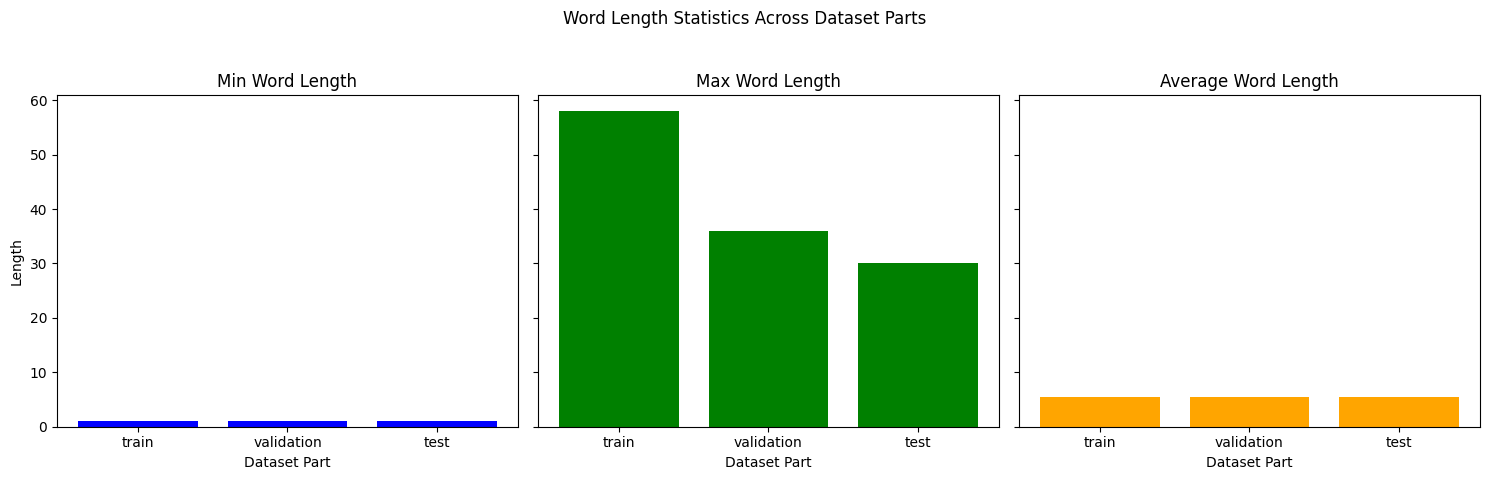

time: 1.75 s (started: 2024-02-21 12:41:16 +00:00)


In [42]:
# Store stats for each dataset part
stats = {}

for part in dataset:
    stats[part] = compute_word_length_stats(dataset[part])

# Data preparation for plotting
parts = list(stats.keys())
min_lengths = [stats[part][0] for part in parts]
max_lengths = [stats[part][1] for part in parts]
avg_lengths = [stats[part][2] for part in parts]

# Set up the matplotlib figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Word Length Statistics Across Dataset Parts')

# Min lengths
ax[0].bar(parts, min_lengths, color='blue')
ax[0].set_title('Min Word Length')
ax[0].set_xlabel('Dataset Part')
ax[0].set_ylabel('Length')

# Max lengths
ax[1].bar(parts, max_lengths, color='green')
ax[1].set_title('Max Word Length')
ax[1].set_xlabel('Dataset Part')

# Avg lengths
ax[2].bar(parts, avg_lengths, color='orange')
ax[2].set_title('Average Word Length')
ax[2].set_xlabel('Dataset Part')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the title
plt.show()

In [43]:
def format_prompt(sample):
    formatted_prompt = f"""
Below is an instruction outlining a specific task, accompanied by an input that offers more detail. Craft a response that effectively addresses the request.

### Instruction:
{sample["instruction"]}

### Input:
{sample["input"]}

### Response:
{sample["output"]}
"""
    # Return the formatted prompt inside a list
    return [formatted_prompt]


time: 515 µs (started: 2024-02-21 12:41:18 +00:00)


In [44]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Hugging Face model name
model_name = "NousResearch/Llama-2-7b-chat-hf"
use_flash_attention = True

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False,
    use_flash_attention_2=use_flash_attention,
    device_map="auto",
    torch_dtype=torch.float16
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

time: 7.01 s (started: 2024-02-21 12:41:18 +00:00)


In [45]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)


time: 370 ms (started: 2024-02-21 12:41:25 +00:00)


In [46]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='NousResearch/Llama-2-7b-chat-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	32000: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
}
time: 1.07 ms (started: 2024-02-21 12:41:25 +00:00)


In [47]:
tokenizer.pad_token = tokenizer.eos_token


time: 330 µs (started: 2024-02-21 12:41:25 +00:00)


In [48]:
tokenizer

LlamaTokenizerFast(name_or_path='NousResearch/Llama-2-7b-chat-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	32000: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
}

time: 2.36 ms (started: 2024-02-21 12:41:25 +00:00)


In [51]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# LoRA config based on QLoRA paper
peft_config = LoraConfig(
    lora_alpha=64,
    lora_dropout=0.0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "down_proj", "gate_proj", "up_proj"]
)
# Prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

time: 2.26 s (started: 2024-02-21 12:41:56 +00:00)


In [52]:
model.print_trainable_parameters()

trainable params: 159,907,840 || all params: 6,898,323,456 || trainable%: 2.3180681656919973
time: 8.31 ms (started: 2024-02-21 12:41:58 +00:00)


In [55]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="llama-7b-chat-hf-medqa-packing-false-padding-left",
    evaluation_strategy="epoch",
    do_eval=True,
    save_strategy="epoch",
    learning_rate=1e-4,
    logging_strategy='epoch', # log according to log_steps
    weight_decay=0.01,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    greater_is_better=True,
    # metric_for_best_model='eval_loss',
    max_grad_norm=0.3,
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",
    group_by_length=True,
    save_safetensors=True,
    report_to="wandb",
    fp16=True,
    seed=42

)

time: 1.41 ms (started: 2024-02-21 12:42:38 +00:00)


In [57]:
from trl import SFTTrainer

max_seq_length = 500 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset = dataset["validation"],
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    packing=False,
    formatting_func=format_prompt,
    args=args,
)

Map:   0%|          | 0/8063 [00:00<?, ? examples/s]

time: 3.89 s (started: 2024-02-21 12:43:09 +00:00)


In [58]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
9.988 GB of memory reserved.
time: 3.54 ms (started: 2024-02-21 12:43:18 +00:00)


In [59]:
import time

time: 319 µs (started: 2024-02-21 12:43:19 +00:00)


In [60]:
start_time = time.time()  # Start timer

trainer_stats = trainer.train()

end_time = time.time()  # End timer
training_duration = (end_time - start_time)/60

print(f"Training Time: {training_duration} minutes")

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


Epoch,Training Loss,Validation Loss
0,0.590200,0.613413
2,0.212500,0.532904


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Training Time: 0.36952728827794395 minutes
time: 22.2 s (started: 2024-02-21 12:43:21 +00:00)


In [67]:
from huggingface_hub import notebook_login
notebook_login()

time: 15.1 ms (started: 2024-02-21 12:51:44 +00:00)


In [62]:
trainer.push_to_hub()

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/640M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DrishtiSharma/llama-7b-chat-hf-medqa-packing-false-padding-left/commit/a0990f18ad7a1cc7ca8df8e9c43a85e0fbfcf2e2', commit_message='End of training', commit_description='', oid='a0990f18ad7a1cc7ca8df8e9c43a85e0fbfcf2e2', pr_url=None, pr_revision=None, pr_num=None)

time: 41.8 s (started: 2024-02-21 12:48:41 +00:00)
